# QA/QC Process Development - CTDBP Example

## Summary
This is a practice of developing a review process, review, and report on the CTD. The goal here is to help develop processes for both Quality Assurance of the data, and algorithms for Quality Control. First, this will start from established methods, processes, and examples. We will want to follow on some of the steps before:

1. Data Availability
    * What data are available?
    * Is the data relevant?
2. Metadata
    * What metadata is available?
    * Is the metadata complete?
    * What does it tell you about the dataset (for good or bad)?
3. Understand the context
    * Plot a large range of data. Does it look right based on what you would expect?
    * What are the ranges?
    * Do the ranges make sense?
4. Focus on one or more smaller subsets of data
    * Plot some smaller periods (in time or space) to see if they look correct or have issues
5. Environmental Comparisons
    * Compare the instrument with independent datasets (such as from CTD casts, satellites, gliders, etc.)
    * How do they compare?
    * Is there anything wrong?

In [2]:
import os, re, requests
import netCDF4 as nc
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pytz

In [3]:
username = 'OOIAPI-C9OSZAQABG1H3U'
token = 'JA48WUQVG7F'

## Step 1. Set up the sensor names, url names, etc.

Lay out the different api urls to use for data requests:

In [4]:
data_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
anno_url = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
vocab_url = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
asset_url = 'https://ooinet.oceanobservatories.org/api/m2m/12587'
deploy_url = asset_url + '/events/deployment/query'
cal_url = asset_url + '/asset/cal'

### Access the data:
The first step is to access the data in a systematic, automatic way, using the M2M interface with the apis. The key is to identify where and what I want to access. I can look at the inventory using the port 12576/sensor/inv systematically find and drill down into the data directories. 

I want to utilize the **CTDBP** on the Coastal Pioneer Central Surface Mooring **CP01CNSM**, which is mounted on the Near-Surface Instrument Frame **RID27**.

In [7]:
# List the site, node, instrument names
site = 'CP01CNSM'
node = 'RID27'
sensor = '03-CTDBPC000'
method = 'recovered_host' # 'recovered_inst' 'telemetered'

In [5]:
# Function to make an API request and print the results
def get_and_print_api(url):
    r = requests.get(url, auth=(username, token))
    data = r.json()
    for d in data:
        print(d)

In [6]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
    if ms is None:
        return None
    else:
        return datetime.datetime.utcfromtimestamp(ms/1000)

### Vocabulary Metadata:
Check out basic instrument vocab (metadata), which will return the reference designator, and allow us to make sure we have the correct instrument:

In [10]:
get_and_print_api(data_url+'/'+site)

MFC31
MFD35
MFD37
RIC21
RID26
RID27
SBC11
SBD11
SBD12


In [12]:
def get_api(url):
    r = requests.get(url, auth=(username, token))
    data = r.json()
    return data

In [13]:
data = get_api(data_url)

In [14]:
data

['CE01ISSM',
 'CE01ISSP',
 'CE02SHBP',
 'CE02SHSM',
 'CE02SHSP',
 'CE04OSBP',
 'CE04OSPD',
 'CE04OSPI',
 'CE04OSPS',
 'CE04OSSM',
 'CE05MOAS',
 'CE06ISSM',
 'CE06ISSP',
 'CE07SHSM',
 'CE07SHSP',
 'CE09OSPM',
 'CE09OSSM',
 'CP01CNPM',
 'CP01CNSM',
 'CP01CNSP',
 'CP02PMCI',
 'CP02PMCO',
 'CP02PMUI',
 'CP02PMUO',
 'CP03ISPM',
 'CP03ISSM',
 'CP03ISSP',
 'CP04OSPM',
 'CP04OSSM',
 'CP05MOAS',
 'GA01SUMO',
 'GA02HYPM',
 'GA03FLMA',
 'GA03FLMB',
 'GA05MOAS',
 'GI01SUMO',
 'GI02HYPM',
 'GI03FLMA',
 'GI03FLMB',
 'GI05MOAS',
 'GP02HYPM',
 'GP03FLMA',
 'GP03FLMB',
 'GP05MOAS',
 'GS01SUMO',
 'GS02HYPM',
 'GS03FLMA',
 'GS03FLMB',
 'GS05MOAS',
 'RS01OSBP',
 'RS01SBPD',
 'RS01SBPS',
 'RS01SHBP',
 'RS01SHDR',
 'RS01SLBS',
 'RS01SUM1',
 'RS01SUM2',
 'RS03ASHS',
 'RS03AXBS',
 'RS03AXPD',
 'RS03AXPS',
 'RS03AXSM',
 'RS03CCAL',
 'RS03ECAL',
 'RS03INT1',
 'RS03INT2',
 'SSRSPACC']

In [8]:
# Retrieve vocabulary information for a given instrument
request_url = '/'.join((vocab_url, site, node, sensor))
r = requests.get(request_url, auth=(username, token))
data = r.json()

In [9]:
data

[{'@class': '.VocabRecord',
  'model': 'SBE 16plusV2',
  'manufacturer': 'Sea-Bird',
  'mindepth': 7.0,
  'maxdepth': 7.0,
  'vocabId': 463,
  'refdes': 'CP01CNSM-RID27-03-CTDBPC000',
  'instrument': 'CTD',
  'tocL1': 'Coastal Pioneer',
  'tocL2': 'Central Surface Mooring',
  'tocL3': 'Near Surface Instrument Frame'}]

So the instrument on the CP01CNSM NSIR is a SBE 16plusV2 at 7 meters of depth.

In [9]:
refdes = data[0]['refdes']
refdes

'CP01CNSM-RID27-03-CTDBPC000'

### Deployment Information
Next, we will get some of the information about the deployments for this instrument. We will get all the deployments available in the system, and output the following: date ranges, latitude/longitude, asset ID, and sensor ID for each. Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the Pioneer Central Surface Mooring), the **Sensor ID** (and its Asset ID equivalent) represents the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [10]:
# Set up the API request url
deploy_request_url = deploy_url
params = {
    'refdes':refdes,
}

# Get the information from the server
r = requests.get(deploy_request_url, params=params, auth=(username, token))
deploy_data = r.json()

In [11]:
def reformat_deployment_data(deploy_data):
    df = pd.DataFrame()
    for d in deploy_data:
        df = df.append({
            'deployment': d['deploymentNumber'],
            'start': convert_time(d['eventStartTime']),
            'stop': convert_time(d['eventStopTime']),
            'latitude': d['location']['latitude'],
            'longitude': d['location']['longitude'],
            'sensor': d['sensor']['assetId'],
        }, ignore_index=True)
    return df

In [12]:
deploy_df = reformat_deployment_data(deploy_data)
deploy_df

,deployment,latitude,longitude,sensor,start,stop
0,1.0,40.136780,-70.76978,2659.0,2013-11-21 18:15:00,2014-04-18 00:00:00
1,2.0,40.133900,-70.77890,1451.0,2014-12-13 18:47:00,2014-12-15 20:58:00
2,3.0,40.140220,-70.77128,1451.0,2015-05-07 17:34:00,2015-10-23 19:40:00
3,4.0,40.133230,-70.77843,2345.0,2015-10-23 18:49:00,2016-04-04 12:03:00
4,5.0,40.140370,-70.77133,1451.0,2016-05-13 13:50:00,2016-10-13 19:34:00
5,6.0,40.133420,-70.77847,2059.0,2016-10-13 18:36:00,2017-06-09 16:05:00
6,7.0,40.139817,-70.77115,2345.0,2017-06-09 14:24:00,2017-11-01 20:33:00
7,8.0,40.133383,-70.77830,2659.0,2017-10-29 14:15:00,2018-03-29 19:37:00
8,9.0,40.139750,-70.77128,2345.0,2018-03-24 21:32:00,2018-10-29 12:31:00
9,10.0,40.133367,-70.77770,2059.0,2018-10-30 01:48:00,NaT


In [13]:
np.unique(deploy_df['sensor'])

array([1451., 2059., 2345., 2659.])

According to the deployment information, there have been 10 deployments of  4 different CTDs on the CP01CNSM NSIF, with asset IDs of 1451, 2059, 2345, 2659. The deployments started on 

In [54]:
str(deploy_df['stop'].iloc[9])

'NaT'

In [259]:
# Develop a function to plot a timeline of deployments
def plot_deployment_timeline(df):
    import matplotlib.dates as mdates
    levels = np.array([-5, 5, -3, 3, -1, 1])
    fig, (ax) = plt.subplots(figsize=(12,6))
    
    # Create a baseline for plotting
    start = min(df['start'])
    stop  = max(df['stop'])
    ax.plot((start, stop), (0, 0), 'k', alpha=0.5)
    
    # Now, iterate through the dates in order to plot and annotate
    deployment = df['deployment']
    asset = df['sensor']
    xdates = df['start']
    ydates = df['stop']
    
    
    for ii, (iname, idate, jdate) in enumerate(zip(deployment, xdates, ydates)):
        # Set some plotting parameters
        level = levels[ii % 6]      # Not sure why/what this is doing
        vert = 'top' if level < 0 else 'bottom'
#        vert2 = 'bottom' if level < 0 else 'top'
        
        # Plot!!!
#        if str(jdate) == 'NaT':
#            pass
#        else:
#            # Plot the stop points
#            ax.scatter(jdate, 0, s=100, marker='s', facecolor='k', edgecolor='k', zorder = 999)
#            # Plot a line to the text
#            ax.plot((jdate, jdate), (0, -level), c='k', alpha=1.0)
#            # Align the stop text properly
#            ax.text(jdate, -level, iname, horizontalalignment='right', verticalalignment=vert2, fontsize=16)
        ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k',  zorder=9999)
        # Plot a line to the text
        ax.plot((idate, idate), (0, level), c='r', alpha=1.0)
        # Align the text properly
        ax.text(idate, level, iname,
                horizontalalignment='right', verticalalignment=vert, fontsize=16)
    
    ax.set(title='Deployments')
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %Y'))
    fig.autofmt_xdate()
    
    # Remove components for easier read
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() + list(ax.spines.values())), visible=False)
    plt.show()
        
    

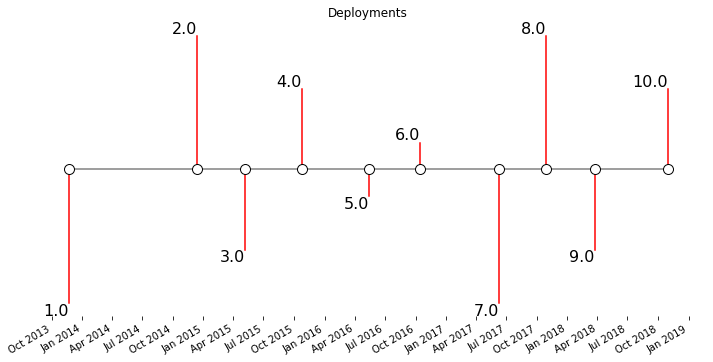

In [260]:
plot_deployment_timeline(deploy_df)

From the table and timeline above about the deployments, there are some time periods where deployments overlap. How to deal with this issue, because it will cause a problem when loading the data due to conflicting "obs" coordinates.

### Calibration Information
When Uframe delivers data, it often uses a number of calibration coefficients to generate derived data products. 

In [60]:
# Set up the API request
cal_request_url = cal_url
params = {
    'refdes':refdes,
}

In [61]:
# Get the information from the server
r = requests.get(cal_request_url, params=params, auth=(username, token))
cal_data = r.json()

In [62]:
def reformat_cal_data(cal_data):
    df = pd.DataFrame()
    for d in cal_data:
        for dd in d['sensor']['calibration']:
            for ddd in dd['calData']:
                df = df.append({
                    'value': ddd['value'],
                    'start': convert_time(ddd['eventStartTime']),
                    'stop': convert_time(ddd['eventStopTime']),
                    'name': ddd['eventName'],
                    'assetUid': ddd['assetUid'],
                    'calSheet': ddd['dataSource'],
                }, ignore_index=True)
    df = df.sort_values(by=['start','name'])
    return df

In [63]:
cal_df = reformat_cal_data(cal_data)

In [70]:
cal_df.head(10)

,assetUid,calSheet,name,start,stop,value
113,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a0,2011-05-18,None,1.301118e-03
201,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a0,2011-05-18,None,1.301118e-03
377,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a0,2011-05-18,None,1.301118e-03
147,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a1,2011-05-18,None,2.561486e-04
235,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a1,2011-05-18,None,2.561486e-04
411,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a1,2011-05-18,None,2.561486e-04
140,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a2,2011-05-18,None,1.896537e-07
228,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a2,2011-05-18,None,1.896537e-07
404,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a2,2011-05-18,None,1.896537e-07
135,CGINS-CTDBPC-06841,CGINS-CTDBPC-06841__20110518_Cal_Info.xlsx,CC_a3,2011-05-18,None,1.301189e-07


## Asynchronous Data Requests
* Return netCDF data from the desired sensor for a desired time period

In [171]:
def get_netcdf_datasets(thredds_url):
    import time
    datasets = []
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/'
    while not datasets:
        datasets = requests.get(thredds_url).text
        urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
        x = re.findall(r'(ooi/.*?.nc)', datasets)
        for i in x:
            if i.endswith('.nc') == False:
                x.remove(i)
        for i in x:
            try:
                float(i[-4])
            except:
                x.remove(i)
        datasets = [os.path.join(tds_url, i) for i in x]
        if not datasets: 
            time.sleep(10)
    return datasets

In [80]:
# Build an URL parser that only keeps your
def parse_dataset_names(dataset_names,refdes):
    for x in dataset_names:
        if x.count(refdes) > 1:
            pass
        else:
            dataset_names.remove(x)
    return dataset_names

In [84]:
# The vocab requests doesn't seem to be working
# Try the instrument information
site = 'CP01CNSM'
node = 'RID27'
sensor = '03-CTDBPC000'
method = 'recovered_inst' # recovered_inst, telemetered
stream = 'ctdbp_cdef_instrument_recovered'

In [87]:
get_and_print_api(data_url+'/'+site+'/'+node+'/'+sensor)

recovered_host
recovered_inst
telemetered


In [167]:
# Setup the data API requests
data_request_url = '/'.join((data_url, site, node, sensor, method, stream))
params = {
    'include_provenance':'true',
    'include_annotations':'true',
}
r = requests.get(data_request_url, params=params, auth=(username, token))
if r.status_code == 200:
    data_urls = r.json()
else:
    print(r.reason)

In [168]:
data_urls['allURLs'][0]

'https://opendap.oceanobservatories.org/thredds/catalog/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

In [169]:
datasets = get_netcdf_datasets(data_urls['allURLs'][0])

In [172]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0008_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20171029T141519-20180329T190320.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0007_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20170609T142931-20171101T202931.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0006_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20161013T183731-20161122T190001.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recove

In [173]:
datasets = parse_dataset_names(datasets,refdes)

In [174]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0008_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20171029T141519-20180329T190320.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0007_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20170609T142931-20171101T202931.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/deployment0006_CP01CNSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered_20161013T183731-20161122T190001.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/areed@whoi.edu/20181210T193515-CP01CNSM-RID27-03-CTDBPC000-recove

In [175]:
ctd_ds = xr.open_mfdataset(datasets)

In [177]:
ctd_ds = ctd_ds.swap_dims({'obs':'time'})

In [185]:
ctd_ds.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:                                  (time: 644541)
Coordinates:
    obs                                      (time) int64 0 1 ... 303451 303452
  * time                                     (time) datetime64[ns] 2017-10-29T14:15:19 ... 2014-02-17T13:27:11
    pressure                                 (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lat                                      (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lon                                      (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
Data variables:
    deployment                               (time) int32 dask.array<shape=(644541,), chunksize=(275778,)>
    id                                       (time) |S64 dask.array<shape=(644541,), chunksize=(275778,)>
    conductivity                             (time) float64 dask.array<shape=(644541,

In [183]:
np.unique(ctd_ds.deployment.values)

array([1, 5, 6, 7, 8])

In [264]:
# Create a function to plot where I have data and where I do not. Will need two things
ctd_ds.data_vars['ctdbp_seawater_pressure']

<xarray.DataArray 'ctdbp_seawater_pressure' (time: 644541)>
dask.array<shape=(644541,), dtype=float64, chunksize=(275778,)>
Coordinates:
    obs       (time) int64 0 1 2 3 4 5 ... 303448 303449 303450 303451 303452
  * time      (time) datetime64[ns] 2017-10-29T14:15:19 ... 2014-02-17T13:27:11
    pressure  (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lat       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lon       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
Attributes:
    comment:                  Seawater Pressure refers to the pressure exerte...
    long_name:                Seawater Pressure
    precision:                3
    data_product_identifier:  PRESWAT_L1
    standard_name:            sea_water_pressure
    units:                    dbar
    ancillary_variables:      pressure,pressure_temp

In [261]:
ctd_ds.data_vars['temperature']

<xarray.DataArray 'temperature' (time: 644541)>
dask.array<shape=(644541,), dtype=float64, chunksize=(275778,)>
Coordinates:
    obs       (time) int64 0 1 2 3 4 5 ... 303448 303449 303450 303451 303452
  * time      (time) datetime64[ns] 2017-10-29T14:15:19 ... 2014-02-17T13:27:11
    pressure  (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lat       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lon       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
Attributes:
    comment:                  Seawater temperature unprocessed measurement ne...
    long_name:                Seawater Temperature Measurement
    precision:                0
    data_product_identifier:  TEMPWAT_L0
    units:                    counts

In [310]:
# do some checks on the difference between the different salinity and temperature fields
ctd_ds.data_vars['preferred_timestamp']

<xarray.DataArray 'preferred_timestamp' (time: 644541)>
dask.array<shape=(644541,), dtype=object, chunksize=(275778,)>
Coordinates:
    obs       (time) int64 0 1 2 3 4 5 ... 303448 303449 303450 303451 303452
  * time      (time) datetime64[ns] 2017-10-29T14:15:19 ... 2014-02-17T13:27:11
    pressure  (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lat       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lon       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
Attributes:
    comment:    Timestamp preferred as official record.
    units:      1
    long_name:  Preferred Timestamp

In [267]:
ctd_ds.coords['time'].values

array(['2017-10-29T14:15:19.000000000', '2017-10-29T14:15:29.000000000',
       '2017-10-29T14:15:39.000000000', ...,
       '2014-02-17T13:26:51.000000000', '2014-02-17T13:27:01.000000000',
       '2014-02-17T13:27:11.000000000'], dtype='datetime64[ns]')

## Preliminary Data Exploration
With the different CTDBP deployment data loaded into datasets, now we'll take a preliminary look at some of the data. This includes plotting L0, L1, and L2 data products for visual comparison and compute some basic statistics.

In [265]:
import seaborn as sns

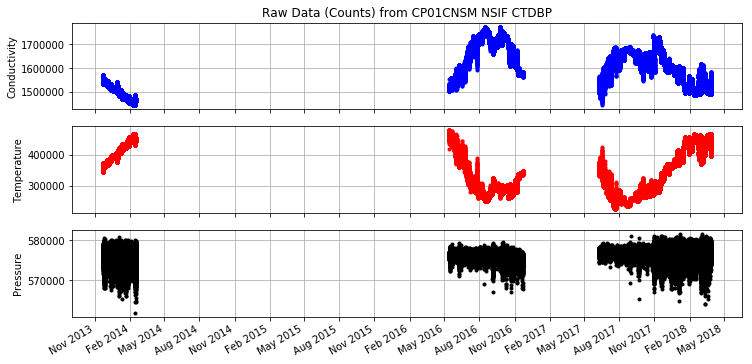

In [277]:
# First, lets plot the raw conductivity, temperature, and pressure
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 6))

# Plot the raw conductivity
ax1.plot_date(x=ctd_ds.coords['time'].values, y=ctd_ds.data_vars['conductivity'].values, marker = '.', color = 'blue')
ax1.set_ylabel('Conductivity')
ax1.grid()
ax1.set_title('Raw Data (Counts) from CP01CNSM NSIF CTDBP')
# Plot the raw temperature
ax2.plot_date(x=ctd_ds.coords['time'].values, y=ctd_ds.data_vars['temperature'].values, marker='.', color = 'red')
ax2.set_ylabel('Temperature')
ax2.grid()
# Plot the raw pressure
ax3.plot_date(x=ctd_ds.coords['time'].values, y=ctd_ds.coords['pressure'].values, marker='.', color='black')
ax3.set_ylabel('Pressure')
ax3.grid()

ax3.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
ax3.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

In [283]:
cond = ctd_ds.data_vars['conductivity']
cond

<xarray.DataArray 'conductivity' (time: 644541)>
dask.array<shape=(644541,), dtype=float64, chunksize=(275778,)>
Coordinates:
    obs       (time) int64 0 1 2 3 4 5 ... 303448 303449 303450 303451 303452
  * time      (time) datetime64[ns] 2017-10-29T14:15:19 ... 2014-02-17T13:27:11
    pressure  (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lat       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
    lon       (time) float64 dask.array<shape=(644541,), chunksize=(275778,)>
Attributes:
    comment:                  Seawater conductivity refers to the ability of ...
    long_name:                Seawater Conductivity Measurement
    precision:                0
    data_product_identifier:  CONDWAT_L0
    units:                    counts

In [287]:
cond = ctd_ds.data_vars['conductivity'].to_dataframe()

In [293]:
cond.sort_index(inplace=True)
cond.head()

,obs,pressure,lat,lon,conductivity
time,,,,,
2013-11-21 18:15:21,0,577543.0,40.13678,-70.76978,1553130.0
2013-11-21 18:15:31,1,576965.0,40.13678,-70.76978,1553348.0
2013-11-21 18:15:41,2,577092.0,40.13678,-70.76978,1553134.0
2013-11-21 18:15:51,3,576412.0,40.13678,-70.76978,1553458.0
2013-11-21 18:16:01,4,577429.0,40.13678,-70.76978,1553237.0


In [302]:
cond.index

DatetimeIndex(['2013-11-21 18:15:21', '2013-11-21 18:15:31',
               '2013-11-21 18:15:41', '2013-11-21 18:15:51',
               '2013-11-21 18:16:01', '2013-11-21 18:16:11',
               '2013-11-21 18:16:21', '2013-11-21 18:16:31',
               '2013-11-21 18:16:41', '2013-11-21 18:16:51',
               ...
               '2018-03-29 19:01:50', '2018-03-29 19:02:00',
               '2018-03-29 19:02:10', '2018-03-29 19:02:20',
               '2018-03-29 19:02:30', '2018-03-29 19:02:40',
               '2018-03-29 19:02:50', '2018-03-29 19:03:00',
               '2018-03-29 19:03:10', '2018-03-29 19:03:20'],
              dtype='datetime64[ns]', name='time', length=644541, freq=None)

In [305]:
cond_rolling_mean=cond.rolling(window='365D').mean()

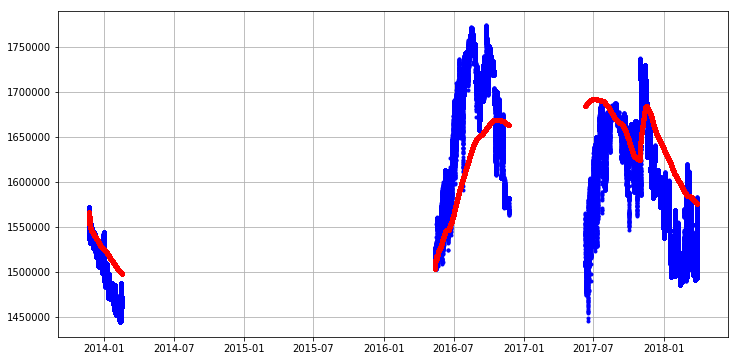

In [306]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot_date(x=cond.index, y=cond['conductivity'], marker='.', color='blue')
ax.plot_date(x=cond_rolling_mean.index, y=cond_rolling_mean['conductivity'], marker='.', color='red')
ax.grid()
